In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [51]:
json_path = "/kaggle/input/transaction-data/user-wallet-transactions.json"
df = pd.read_json(json_path)
df = pd.json_normalize(df.to_dict(orient='records'))
df.head()

,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,__v,_id.$oid,...,actionData.repayerId,actionData.liquidatorId,actionData.collateralAmount,actionData.collateralAssetPriceUSD,actionData.principalAmount,actionData.borrowAssetPriceUSD,actionData.collateralReserveId,actionData.collateralReserveSymbol,actionData.principalReserveId,actionData.principalReserveSymbol
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,0,681d38fed63812d4655f571a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,0,681aa70dd6df53021cc6f3c0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,0,681d04c2d63812d4654c733e,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,0,681d133bd63812d46551b6ef,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,0,681899e4ba49fc91cf2f4454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df.columns

Index(['userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp',
       'blockNumber', 'action', '__v', '_id.$oid', 'actionData.type',
       'actionData.amount', 'actionData.assetSymbol',
       'actionData.assetPriceUSD', 'actionData.poolId', 'actionData.userId',
       'createdAt.$date', 'updatedAt.$date', 'actionData.toId',
       'actionData.borrowRateMode', 'actionData.borrowRate',
       'actionData.variableTokenDebt', 'actionData.stableTokenDebt',
       'actionData.callerId', 'actionData.useATokens', 'actionData.repayerId',
       'actionData.liquidatorId', 'actionData.collateralAmount',
       'actionData.collateralAssetPriceUSD', 'actionData.principalAmount',
       'actionData.borrowAssetPriceUSD', 'actionData.collateralReserveId',
       'actionData.collateralReserveSymbol', 'actionData.principalReserveId',
       'actionData.principalReserveSymbol'],
      dtype='object')

In [54]:
df.userWallet

0        0x00000000001accfa9cef68cf5371a23025b6d4b6
1        0x000000000051d07a4fb3bd10121a343d85818da6
2        0x000000000096026fb41fc39f9875d164bd82e2dc
3        0x000000000096026fb41fc39f9875d164bd82e2dc
4        0x0000000000e189dd664b9ab08a33c4839953852c
                            ...                    
99995    0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a
99996    0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a
99997    0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a
99998    0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a
99999    0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a
Name: userWallet, Length: 100000, dtype: object

In [56]:

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['action'] = df['action'].str.lower()


df['actionData.amount'] = pd.to_numeric(df['actionData.amount'], errors='coerce')
df['actionData.assetPriceUSD'] = pd.to_numeric(df['actionData.assetPriceUSD'], errors='coerce')
df = df.dropna(subset=['actionData.amount', 'actionData.assetPriceUSD'])


df['amount_token'] = df['actionData.amount'] / (10**18)
df['amount_usd'] = df['amount_token'] * df['actionData.assetPriceUSD']


df['ts_seconds'] = df['timestamp'].astype(np.int64) // 10**9

df[['userWallet', 'action', 'amount_usd', 'timestamp']].head()


,userWallet,action,amount_usd,timestamp
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,1.987664e-09,2021-08-17 05:29:26
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,2.856945e+02,2021-05-20 15:36:53
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,9.223773e-04,2021-07-24 09:28:33
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,4.229933e-03,2021-07-31 23:15:18
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,5.026161e-13,2021-04-19 15:25:07


In [57]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

df['ts_seconds'] = df['timestamp'].astype(np.int64) // 10**9  # convert to UNIX seconds

agg_df = df.groupby(['userWallet', 'action']).agg({
    'amount_usd': ['sum', 'mean'],
    'ts_seconds': ['min', 'max', 'count']})

agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df = agg_df.unstack().fillna(0)
agg_df.columns = ['{}_{}'.format(a, b) for a, b in agg_df.columns]
agg_df.reset_index(inplace=True)

np.random.seed(42)
def rule_based_score(row):
    score = 600
    score += row.get("amount_usd_sum_deposit", 0) * 0.01  # more deposits = higher score
    score -= row.get("ts_seconds_count_liquidationcall", 0) * 100  # penalize liquidations
    score += row.get("ts_seconds_count_repay", 0) * 10  # reward repay behavior
    return min(1000, max(0, score))  # Clamp between 0–1000

agg_df['credit_score'] = agg_df.apply(rule_based_score, axis=1)


agg_df.head()


,userWallet,amount_usd_sum_borrow,amount_usd_sum_deposit,amount_usd_sum_liquidationcall,amount_usd_sum_redeemunderlying,amount_usd_sum_repay,amount_usd_mean_borrow,amount_usd_mean_deposit,amount_usd_mean_liquidationcall,amount_usd_mean_redeemunderlying,...,ts_seconds_max_deposit,ts_seconds_max_liquidationcall,ts_seconds_max_redeemunderlying,ts_seconds_max_repay,ts_seconds_count_borrow,ts_seconds_count_deposit,ts_seconds_count_liquidationcall,ts_seconds_count_redeemunderlying,ts_seconds_count_repay,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,0.000000,1.987664e-09,0.0,0.000000,0.000000e+00,0.000000,1.987664e-09,0.0,0.000000,...,1.629178e+09,0.0,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0.0,0.0,600.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,0.000000,2.856945e+02,0.0,0.000000,0.000000e+00,0.000000,2.856945e+02,0.0,0.000000,...,1.621525e+09,0.0,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0.0,0.0,602.856945
2,0x000000000096026fb41fc39f9875d164bd82e2dc,0.000000,5.152311e-03,0.0,0.000000,0.000000e+00,0.000000,2.576155e-03,0.0,0.000000,...,1.627773e+09,0.0,0.000000e+00,0.000000e+00,0.0,2.0,0.0,0.0,0.0,600.000052
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.000000,0.000000e+00,0.0,980.360032,0.000000e+00,0.000000,0.000000e+00,0.0,57.668237,...,0.000000e+00,0.0,1.630020e+09,0.000000e+00,0.0,0.0,0.0,17.0,0.0,600.000000
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,60297.620862,2.065773e+05,0.0,112874.520280,7.015026e-08,4019.841391,8.263093e+02,0.0,868.265541,...,1.630520e+09,0.0,1.629911e+09,1.621597e+09,15.0,250.0,0.0,130.0,4.0,1000.000000


In [58]:
X = agg_df.drop(columns=['userWallet', 'credit_score'])
y = agg_df['credit_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [59]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [60]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")


MAE  : 2.47
RMSE : 11.65
R²   : 0.9919


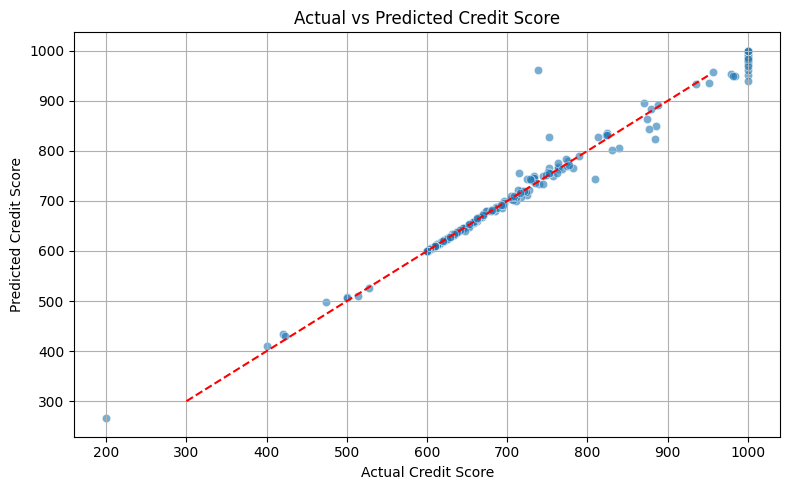

In [61]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([300, 950], [300, 950], '--', color='red')
plt.xlabel("Actual Credit Score")
plt.ylabel("Predicted Credit Score")
plt.title("Actual vs Predicted Credit Score")
plt.grid(True)
plt.tight_layout()
plt.show()


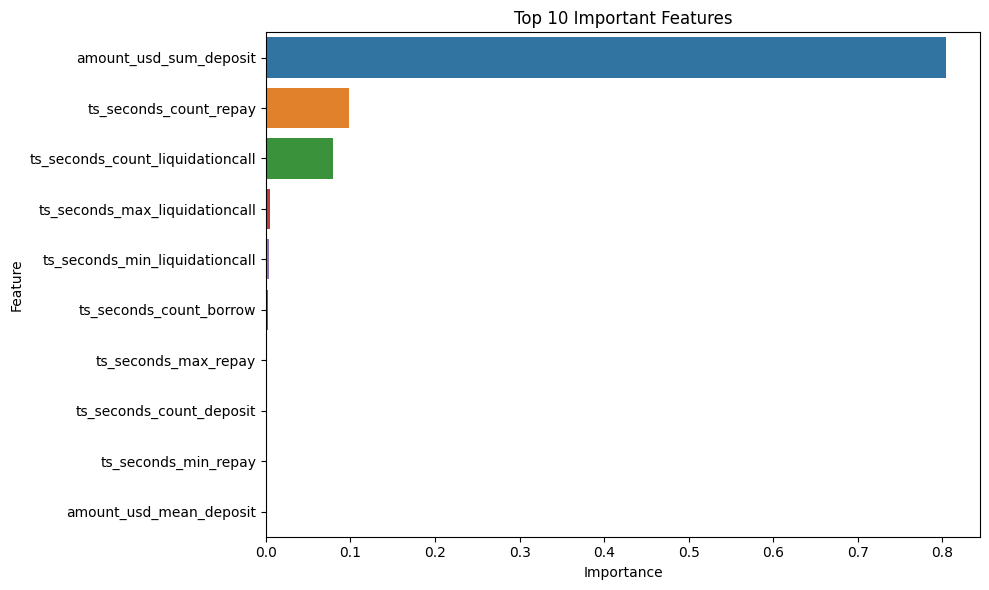

In [62]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices[:10]], y=feature_names[indices[:10]])
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
